Scott Scheraga Research week 1- modified HW2 from RL Class. 


Code is largely built off of and modified from https://keras.io/examples/rl/ddpg_pendulum/

I have also annotated a lot of it. 

https://github.com/benelot/pybullet-gym


https://github.com/openai/gym/blob/master/docs/environments.md#pybullet-robotics-environments
https://docs.google.com/document/d/10sXEhzFRSnvFcl3XxNGhnD4N2SedqwdAvK3dsihxVUA/edit#heading=h.wz5to0x8kqmr



In [1]:
import gym
import pybullet_envs
import pybulletgym 
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from gym import wrappers
from IPython import display
from datetime import datetime
%matplotlib inline

In [2]:
#Set the environment:
#env = gym.make('Pendulum-v0')
#env = gym.make('CartPole-v1')
#env = gym.make('HalfCheetahBulletEnv-v0')
env = gym.make('ReacherPyBulletEnv-v0')
#env = gym.make('PusherPyBulletEnv-v0')

print(env.observation_space.shape)
print(env.action_space.shape)

num_states = env.observation_space.shape[0]
print("Size of State Space ->  {}".format(num_states))
#print(env.action_space)

#num_actions=1
num_actions = env.action_space.shape[0]
print("Size of Action Space ->  {}".format(num_actions))

upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]
#upper_bound =2.0
#lower_bound =-2.0
print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))


(9,)
(2,)
Size of State Space ->  9
Size of Action Space ->  2
Max Value of Action ->  1.0
Min Value of Action ->  -1.0


/home/scott/gym/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [8]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)


In [9]:
class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=256):
    
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch)
            y = reward_batch + gamma * target_critic([next_state_batch, target_actions])
            critic_value = critic_model([state_batch, action_batch])
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch)
            critic_value = critic_model([state_batch, actions])
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
def update_target(tau):
    new_weights = []
    target_variables = target_critic.weights
    for i, variable in enumerate(critic_model.weights):
        new_weights.append(variable * tau + target_variables[i] * (1 - tau))

    target_critic.set_weights(new_weights)

    new_weights = []
    target_variables = target_actor.weights
    for i, variable in enumerate(actor_model.weights):
        new_weights.append(variable * tau + target_variables[i] * (1 - tau))

    target_actor.set_weights(new_weights)


In [10]:
def get_actor():  #makes actor network
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(512, activation="relu")(inputs)
    out = layers.BatchNormalization()(out)
    out = layers.Dense(512, activation="relu")(out)
    out = layers.BatchNormalization()(out)
    outputs = layers.Dense(num_actions, activation="tanh", kernel_initializer=last_init)(out)
    # Our upper bound is 2.0 for Pendulum.
    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model

def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states))
    #state_out = layers.Dense(16, activation="relu")(state_input)
    #state_out = layers.BatchNormalization()(state_out)
    #state_out = layers.Dense(32, activation="relu")(state_out)
    #state_out = layers.BatchNormalization()(state_out) 

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    #action_out = layers.Dense(32, activation="relu")(action_input)  
    #action_out = layers.BatchNormalization()(action_out)
    
    
    # Both are passed through seperate layer before concatenating
    #NOT USED: concat = layers.Concatenate()([state_out, action_out])
    concat = layers.Concatenate()([state_input, action_input])

    out = layers.Dense(512, activation="relu")(concat)
    out = layers.BatchNormalization()(out)
    out = layers.Dense(512, activation="relu")(out)
    out = layers.BatchNormalization()(out)
    outputs = layers.Dense(6)(out)

    model = tf.keras.Model([state_input, action_input], outputs)

    return model


In [11]:
def policy(state, noise_object):
    sampled_actions = tf.squeeze(actor_model(state))
    noise = noise_object()
    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + noise

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    return np.squeeze(legal_action)


In [12]:
std_dev = 0.2
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 0.001  #originally .002
actor_lr = 0.0001  #originally .001

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

# Discount factor for future rewards
gamma = 0.99
# Used to update target networks
tau = 0.01

buffer = Buffer(50000, 64)
# To store reward history of each episode
ep_reward_list = []

Time is:  2020-09-07 14:30:17.832202
Episode * 0 *  Episodic Reward: 6.043155809162169
Episode * 1 *  Episodic Reward: -0.5437788066951763
Episode * 2 *  Episodic Reward: 5.234141251693775
Episode * 3 *  Episodic Reward: -8.002283591927611
Episode * 4 *  Episodic Reward: 16.15486330898787
Episode * 5 *  Episodic Reward: 10.606233208181166
Episode * 6 *  Episodic Reward: -2.806333374578896
Episode * 7 *  Episodic Reward: -13.12263124968974
Episode * 8 *  Episodic Reward: 4.726051653097928
Episode * 9 *  Episodic Reward: 15.724925747947248
Episode * 10 *  Episodic Reward: 2.2088760256653797
Episode * 11 *  Episodic Reward: -11.046707426204847
Episode * 12 *  Episodic Reward: 24.37444662274533
Episode * 13 *  Episodic Reward: -2.0458992543555437
Episode * 14 *  Episodic Reward: -0.9984553275152115
Episode * 15 *  Episodic Reward: 3.8911422393628854
Episode * 16 *  Episodic Reward: 21.242772791122796
Episode * 17 *  Episodic Reward: 1.744014842283169
Episode * 18 *  Episodic Reward: -7.390

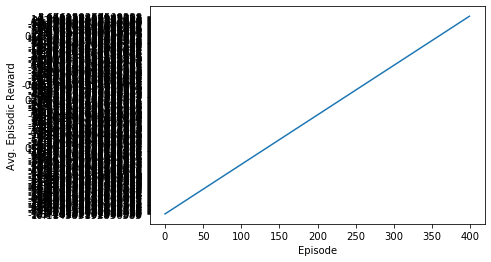

In [13]:
# To store average reward history of last few episodes
#avg_reward_list = []
actor_model.load_weights("reach_actor100.h5")
critic_model.load_weights("reach_critic100.h5")

target_actor.load_weights("reach_target_actor100.h5")
target_critic.load_weights("reach_target_critic100.h5")

with open('reach_rewardlist100.txt', 'r') as filehandle:
    for line in filehandle:
        # remove linebreak which is the last character of the string
        currentPlace = line[:-1]

        # add item to the list
        ep_reward_list.append(currentPlace)

env.render()

dateTimeObj = datetime.now()

print("Time is: ", dateTimeObj)

#Episodes to train
for ep in range(100):

    prev_state = env.reset()
    episodic_reward = 0
    
    #Timesteps within episode
    for g in range (100):
        
    #while True: # "While True" doesnt seem to work


        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

        action = policy(tf_prev_state, ou_noise)
        # Recieve state and reward from environment.
        state, reward, done, info = env.step(action)

        buffer.record((prev_state, action, reward, state))
        episodic_reward += reward

        buffer.learn()
        update_target(tau)

        # End this episode when `done` is True
        #if done:
           # break

        prev_state = state

    ep_reward_list.append(episodic_reward)

    # Mean of last 40 episodes
    #avg_reward = np.mean(ep_reward_list[-40:])
    print("Episode * {} *  Episodic Reward: {}".format(ep, episodic_reward ))
    #avg_reward_list.append(avg_reward)
    
dateTimeObj = datetime.now()
print("Time is: ", dateTimeObj)

# Plotting graph
# Episodes versus Avg. Rewards
plt.plot(ep_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Episodic Reward")
plt.show()

actor_model.save_weights("reach_actor100.h5")
critic_model.save_weights("reach_critic100.h5")

target_actor.save_weights("reach_target_actor100.h5")
target_critic.save_weights("reach_target_critic100.h5")

with open('reach_rewardlist100.txt', 'w') as filehandle:
    for listitem in ep_reward_list:
        filehandle.write('%s\n' % listitem)
        
   

In [19]:
#Load weights from saved file for in-notebook simulation
actor_model.load_weights("reach_actor100.h5")
critic_model.load_weights("reach_critic100.h5")

target_actor.load_weights("reach_target_actor100.h5")
target_critic.load_weights("reach_target_critic100.h5")



"\nwith open('rewardlist200v8.txt', 'w') as filehandle:\n    for listitem in ep_reward_list:\n        filehandle.write('%s\n' % listitem)\n"

In [ ]:
#To display simulation within jupyter notebook. Not the greatest display though

env.reset()
img = plt.imshow(env.render(mode='rgb_array')) 
for _ in range(50):
    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)
    action = env.action_space.sample()
    #env.step(action)  #investigate 
    env.render()